# Shape Frequency Explorations

This notebook explores some shape properties of oscillations.

In particular, it explores instantaneous frequency measures of shapey oscillations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from neurodsp.utils import create_times
from neurodsp.sim import sim_oscillation, sim_cycle

from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum
from neurodsp.timefrequency import phase_by_time, freq_by_time
from neurodsp.plts import plot_time_series, plot_instantaneous_measure

from fooof.plts import plot_spectrum

In [2]:
# Notebook Settings
SAVE_FIG = False

# Instantaneous Frequency of Asymmetric Oscillations

### Settings

In [3]:
# General simulation settings
n_seconds = 10
fs = 1000
times = create_times(n_seconds, fs)

freq = 8
f_range = (freq-2, freq+2)

# Define a series of rise-decay symmetris to simulate
rdsyms = [0.5, 0.625, 0.75, 0.875, 0.99]
n_sims = len(rdsyms)

### Simulate shape-y oscillations 

In [4]:
sigs, filts, psds = [], [], []
for rdsym in rdsyms:
    
    sig = sim_oscillation(n_seconds, fs, freq, 'asine', rdsym=rdsym)
    filt = filter_signal(sig, fs, 'bandpass', (freq-2, freq+2))

    freqs, psd = compute_spectrum(sig, fs)
    
    sigs.append(sig)
    filts.append(filt)
    psds.append(psd)

### Plot Shape-y Oscillations

In each case, the coloured trace is the filtered oscillation, and the gray trace is the raw signal.

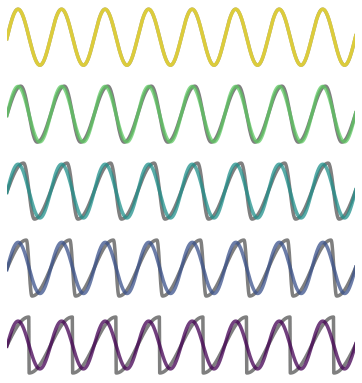

In [5]:
fig, axes = plt.subplots(n_sims, 1, figsize=(6, 6))
colors = [plt.cm.viridis(ind) for ind in np.linspace(1, 0, len(rdsyms))]
for sig, filt, ax, color in zip(sigs, filts, axes, colors):
    plot_time_series(times, [sig, filt], colors=['black', color],
                     lw=3.5, alpha=[0.5, 0.75], xlim=[1, 2], ax=ax)
    ax.axis('off')
plt.subplots_adjust(hspace=0.25)

if SAVE_FIG: plt.savefig('img/time_series.pdf', bbox_inches='tight')

### Compare power spectra of shapy-signals

Next, let's compare the spectra of the simulated signals.

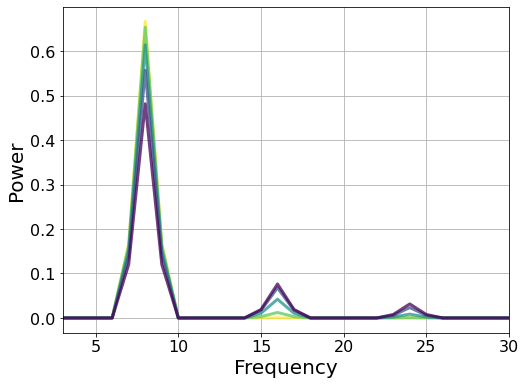

In [6]:
_, ax = plt.subplots(figsize=(8, 6))
for psd, color in zip(psds, colors):
    plot_spectrum(freqs, psd, ax=ax, lw=3, alpha=0.75, color=color)
    plt.gca().set_xlim([3, 30])
if SAVE_FIG: plt.savefig('img/spectra.pdf', bbox_inches='tight')

### Calculate instantaneous phase

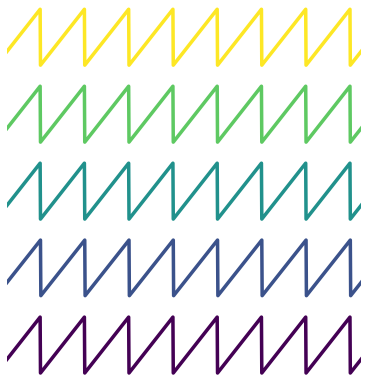

In [7]:
fig, axes = plt.subplots(n_sims, 1, figsize=(6, 6))
colors = [plt.cm.viridis(ind) for ind in np.linspace(1, 0, len(rdsyms))]
phas = []
for filt, ax, color in zip(filts, axes, colors):
    
    pha = phase_by_time(filt, fs)
    phas.append(pha)
    plot_instantaneous_measure(times, pha, 'phase', colors=color, lw=3.5,
                               ax=ax, xlim=[1, 2])
    ax.axis('off')
plt.subplots_adjust(hspace=0.25)
if SAVE_FIG: plt.savefig('img/iphases.pdf', bbox_inches='tight')

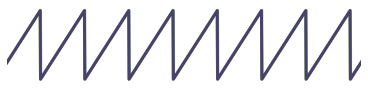

In [8]:
# Plot all instaneous traces on top of each other
_, ax = plt.subplots(figsize=(6, 2))
plot_instantaneous_measure(times, phas, 'phase', xlim=[1, 2],
                           colors=colors, lw=3, alpha=0.5, ax=ax)
plt.gca().axis('off');
if SAVE_FIG: plt.savefig('img/iphase_all.pdf', bbox_inches='tight')

### Calculate Instantaneous Frequency

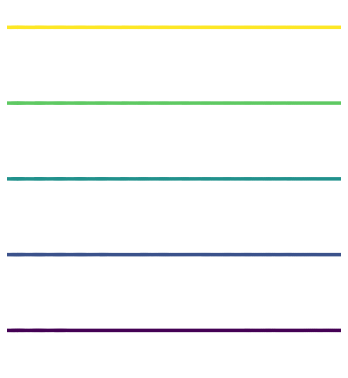

In [9]:
fig, axes = plt.subplots(n_sims, 1, figsize=(6, 6))
colors = [plt.cm.viridis(ind) for ind in np.linspace(1, 0, len(rdsyms))]
ifreqs = []
for filt, ax, color in zip(filts, axes, colors):
    
    ifreq = freq_by_time(filt, fs)
    ifreqs.append(ifreq)
    plot_instantaneous_measure(times, ifreq, 'frequency', colors=color, lw=3.5,
                               ax=ax, xlim=[1, 2], ylim=[4, 10])
    ax.axis('off')
plt.subplots_adjust(hspace=0.25)
if SAVE_FIG: plt.savefig('img/ifreqs.pdf', bbox_inches='tight')

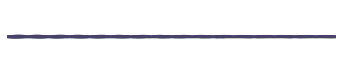

In [10]:
# Plot all instaneous traces on top of each other
_, ax = plt.subplots(figsize=(6, 2))
plot_instantaneous_measure(times, ifreqs, 'frequency', xlim=[1, 2],
                           colors=colors, lw=3, alpha=0.5, ax=ax)
plt.gca().axis('off');
if SAVE_FIG: plt.savefig('img/ifreq_all.pdf', bbox_inches='tight')

### Interim Summary

In the above, we simulated oscillations with different shape properties. 

Notably, applying a filter smooths out the shape-ness, and enforces sinusoidality. 

Because of this, instantaneous phase and frequency measures are smooth. 
- iphase is not totally accurate, since the filter smooth the shape of the simulated signals.
- ifreq measures are pretty much totally accurate. 

Conclusions: constant asymmetric oscillations get smoothed by filtering, and lead to accurate instantaneous frequency measures. 

## Define Helper Functions

Note: here we add a sim function for one-sided asymmetric cycles, that is useful for some of the next sims. 

This function is in the process of being added to `neurodsp`, and can be removed from this notebook when merged. 

In [11]:
def sim_asine_cycle(n_seconds, fs, rdsym, side='peak'):
    """Simulate asymetric cycle with only one asymmetric extrema."""
    
    # Determine number of samples
    n_samples = int(n_seconds * fs)
    half_sample = int(n_samples/2)

    # Calculate number of samples rising
    n_rise_tot = int(np.round(n_samples * rdsym))
    n_rise_start = int(np.ceil(n_rise_tot/2))
    n_rise_end = int(np.floor(n_rise_tot/2))

    # Calculate number of samples decaying
    n_decay_full = n_samples - n_rise_tot
    n_decay_half = half_sample - n_rise_start

    # Calculate step size of one sample, to offset ranges, as needed
    offset = (1/n_samples * 2*np.pi)

    # Create phase defintion for cycle with only one extrema being asymmetric
    phase = np.hstack([np.linspace(0, np.pi/2, n_rise_start),
                       np.linspace(np.pi/2, np.pi, n_decay_half),
                       np.linspace(np.pi + offset, 2*np.pi-offset, half_sample)])

    # Convert phase definition to signal
    cycle = np.sin(phase)

    # For asymmetric trough, rotate and flip the generated cycle
    if side == 'trough':
        cycle = -1 * phase_shift_cycle(cycle, 0.5)

    return cycle

# Instantaneous Frequency of Variable Asymmetric Oscillations

Next, we will measures of instantaneous frequency when there is a change in oscillatory properties, including of shape. 

Each of the following demos has the same setup: two segments are simulated, with a change of a single feature in the second segment. 

The combined signals are then analyzed for instantaneous frequency, to see what a change in the manipulated feature does. 

Note that the first couple examples concatenate segments without changes, to show that the concatenation itself doesn't induce artifacts. 

### Settings

In [12]:
# Simulation settings
n_seconds = 6
fs = 1000

times = create_times(n_seconds, fs, -3)

freq = 10
f_range = (freq-4, freq+4)


# Plot settings
figsize = (10, 5)
xlim = [-1., 1.]
if_range = (freq-0.5, freq+0.5)

### Sinusoidal oscillation

In [13]:
part1 = sim_oscillation(n_seconds/2, fs, freq)
part2 = sim_oscillation(n_seconds/2, fs, freq)
comb = np.hstack([part1, part2])

In [14]:
filt = filter_signal(comb, fs, 'bandpass', f_range)
ifreq = freq_by_time(comb, fs, f_range)

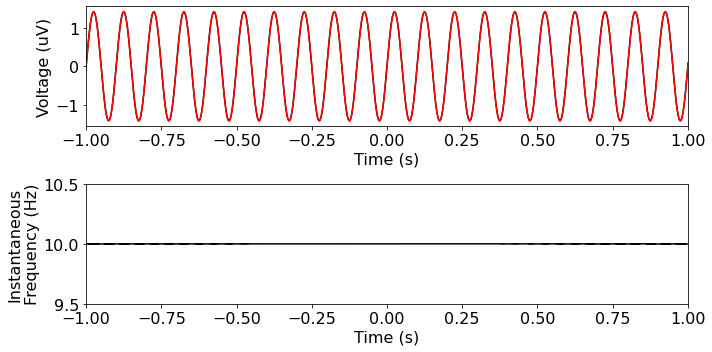

In [15]:
_, axes = plt.subplots(2, 1, figsize=figsize)
plot_time_series(times, [comb, filt], xlim=xlim, ax=axes[0])
plot_instantaneous_measure(times, ifreq, 'frequency', xlim=xlim, ylim=if_range, ax=axes[1])
if SAVE_FIG: plt.savefig('img/steady_sine.pdf', bbox_inches='tight')

## Asymmetric Oscillation

In [16]:
part1 = sim_oscillation(n_seconds/2, fs, freq, 'asine', rdsym=0.75)
part2 = sim_oscillation(n_seconds/2, fs, freq, 'asine', rdsym=0.75)
comb = np.hstack([part1, part2])

In [17]:
shape_filt = filter_signal(comb, fs, 'bandpass', f_range)
shape_ifreq = freq_by_time(comb, fs, f_range)

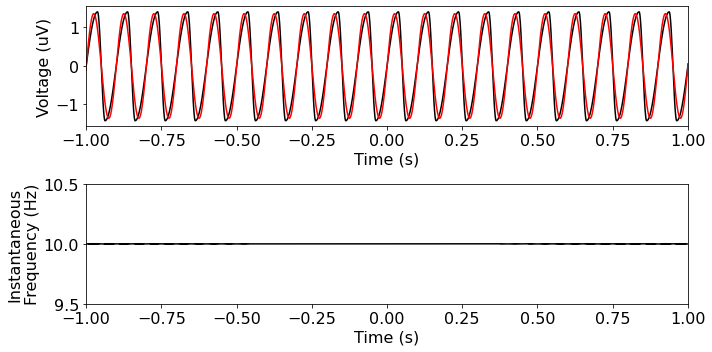

In [18]:
_, axes = plt.subplots(2, 1, figsize=figsize)
plot_time_series(times, [comb, shape_filt], xlim=xlim, ax=axes[0])
plot_instantaneous_measure(times, ifreq, 'frequency', xlim=xlim, ylim=if_range, ax=axes[1])
if SAVE_FIG: plt.savefig('img/steady_asine.pdf', bbox_inches='tight')

## Change in shape oscillation

In [19]:
part1 = sim_oscillation(n_seconds/2, fs, freq)
part2 = sim_oscillation(n_seconds/2, fs, freq, 'asine', rdsym=0.1)
comb = np.hstack([part1, part2])

In [20]:
comb_filt = filter_signal(comb, fs, 'bandpass', f_range)
comb_ifreq = freq_by_time(comb, fs, f_range)

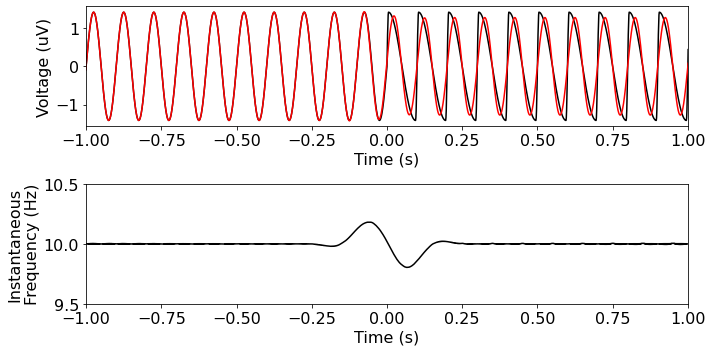

In [21]:
_, axes = plt.subplots(2, 1, figsize=figsize)
plot_time_series(times, [comb, comb_filt], xlim=xlim, ax=axes[0])
plot_instantaneous_measure(times, comb_ifreq, 'frequency', xlim=xlim, ylim=if_range, ax=axes[1])
if SAVE_FIG: plt.savefig('img/change_shape.pdf', bbox_inches='tight')

## Change in shape (half) 

In [22]:
part1 = sim_oscillation(n_seconds/2, fs, freq)
part2 = sim_oscillation(n_seconds/2, fs, freq, sim_asine_cycle, rdsym=0.1)
comb = np.hstack([part1, part2])

In [23]:
comb_filt = filter_signal(comb, fs, 'bandpass', f_range)
comb_ifreq = freq_by_time(comb, fs, f_range)

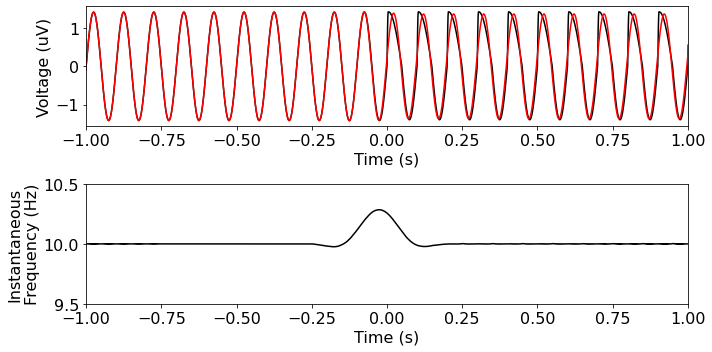

In [24]:
_, axes = plt.subplots(2, 1, figsize=figsize)
plot_time_series(times, [comb, comb_filt], xlim=xlim, ax=axes[0])
plot_instantaneous_measure(times, comb_ifreq, 'frequency', xlim=xlim, ylim=if_range, ax=axes[1])
if SAVE_FIG: plt.savefig('img/change_shape_half.pdf', bbox_inches='tight')

## Single cycle shape change

In [25]:
part1 = sim_oscillation(n_seconds/2, fs, freq)
cyc = sim_asine_cycle(1/(freq + 0.5), fs, rdsym=0.1, side='peak') * 1.4
comb = np.hstack([part1, cyc, part1])[0:len(times)]

In [26]:
comb_filt = filter_signal(comb, fs, 'bandpass', f_range)
comb_ifreq = freq_by_time(comb, fs, f_range)

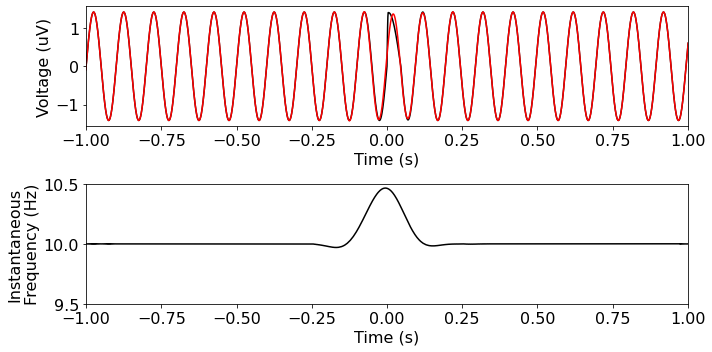

In [27]:
_, axes = plt.subplots(2, 1, figsize=figsize)
plot_time_series(times, [comb, comb_filt], xlim=xlim, ax=axes[0])
plot_instantaneous_measure(times, comb_ifreq, 'frequency', xlim=xlim, ylim=if_range, ax=axes[1])
if SAVE_FIG: plt.savefig('img/onecyc_shape.pdf', bbox_inches='tight')

## Change in frequency

In [28]:
part1 = sim_oscillation(n_seconds/2, fs, freq)
part2 = sim_oscillation(n_seconds/2, fs, freq + 0.5)
comb = np.hstack([part1, part2])

In [29]:
comb_filt = filter_signal(comb, fs, 'bandpass', f_range)
comb_ifreq = freq_by_time(comb, fs, f_range)

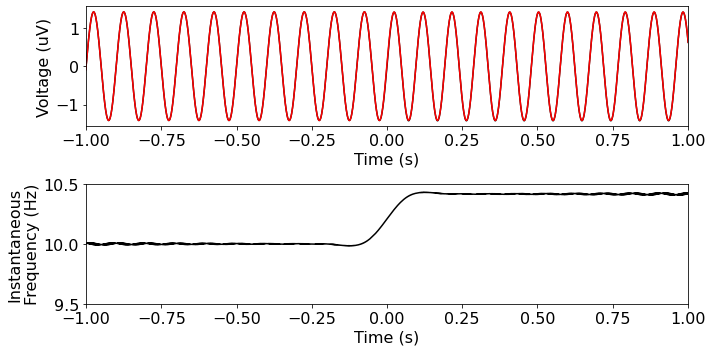

In [30]:
_, axes = plt.subplots(2, 1, figsize=figsize)
plot_time_series(times, [comb, comb_filt], xlim=xlim, ax=axes[0])
plot_instantaneous_measure(times, comb_ifreq, 'frequency', xlim=xlim, ylim=if_range, ax=axes[1])
if SAVE_FIG: plt.savefig('img/change_freq.pdf', bbox_inches='tight')

## Single cycle frequency change

In [31]:
part1 = sim_oscillation(n_seconds/2, fs, freq)
cyc = sim_cycle(1/(freq + 0.5), fs, 'sine') * 1.4
comb = np.hstack([part1, cyc, part1])[0:len(times)]

In [32]:
comb_filt = filter_signal(comb, fs, 'bandpass', f_range)
comb_ifreq = freq_by_time(comb, fs, f_range)

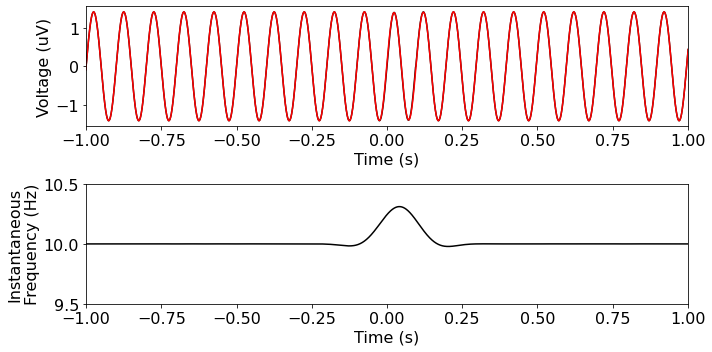

In [33]:
_, axes = plt.subplots(2, 1, figsize=figsize)
plot_time_series(times, [comb, comb_filt], xlim=xlim, ax=axes[0])
plot_instantaneous_measure(times, comb_ifreq, 'frequency', xlim=xlim, ylim=if_range, ax=axes[1])
if SAVE_FIG: plt.savefig('img/onecyc_freq.pdf', bbox_inches='tight')